In [1]:
#Load in a bunch of useful functions:

import numpy as np
import matplotlib.pyplot as plt
from importlib import reload

import Detectors.Deep_Learning.AutoEncoders.utils
reload(Detectors.Deep_Learning.AutoEncoders.utils)
from Detectors.Deep_Learning.AutoEncoders.utils import SeqDataset,train_epoch,eval_data,train_model

# import flow.visualize.visualize_ring as visualize_ring
# reload(visualize_ring)
# from flow.visualize.visualize_ring import get_measured_leader,get_rel_dist_to_measured_leader,get_vel_of_measured_leader



import torch

# Anti-Flow specific functions for  detection:

from Detectors.Deep_Learning.AutoEncoders.utils import sliding_window
from Detectors.Deep_Learning.AutoEncoders.cnn_lstm_ae import CNNRecurrentAutoencoder

import utils
reload(utils)
from utils import Bando_OVM_FTL

import os

print('Libraries loaded.')


import Adversaries.controllers.car_following_adversarial
from Adversaries.controllers.car_following_adversarial import FollowerStopper_Overreact
from Adversaries.controllers.car_following_adversarial import ACC_Benign


import time

from Detectors.Deep_Learning.AutoEncoders.utils import SeqDataset,train_epoch,eval_data,train_model,get_cnn_lstm_ae_model,make_train_X,sliding_window_mult_feat

from Detectors.Deep_Learning.AutoEncoders.utils import get_loss_filter_indiv as loss_smooth

import flow.visualize.visualize_ring as visualize_ring

from flow.visualize.visualize_ring import get_measured_leader,get_rel_dist_to_measured_leader,get_vel_of_measured_leader

from copy import deepcopy

import sys


print('Imported detection tools.')


Libraries loaded.
Imported detection tools.


In [27]:
def train_ring_relative_detector(GPS_penetration_rate,timeseries_dict,model_name='ARED_detector',n_epoch=50):

#     warmup_period = 50 #Wait until there's a well developed wave

    veh_ids = list(timeseries_dict.keys())

    num_measured_vehicle_ids = int(np.floor(len(veh_ids)*GPS_penetration_rate))
    measured_veh_ids = deepcopy(veh_ids)

    for i in range(len(measured_veh_ids)-num_measured_vehicle_ids):
        rand_int = np.random.randint(0,len(measured_veh_ids))
        del measured_veh_ids[rand_int]

    timeseries_list = []

    for veh_id in measured_veh_ids:
        #[time,speed,headway,accel,leader_speed,fuel_consumption]
        speed = timeseries_dict[veh_id][:,1]
        accel = np.gradient(speed,.1)
        head_way = timeseries_dict[veh_id][:,2]
        rel_vel = timeseries_dict[veh_id][:,3]
        
        timeseries_list.append([speed,accel,head_way,rel_vel])

    train_X = make_train_X(timeseries_list)

    model = get_cnn_lstm_ae_model(n_features=4)

    model_file_name = model_name+str(GPS_penetration_rate)+'percentGPS'

    print('Model: '+model_file_name)

    print('Beginning training...')
    begin_time = time.time()
    model = train_model(model,train_X,model_file_name,n_epoch=n_epoch)
    finish_time = time.time()
    print('Finished training, total time: '+str(finish_time-begin_time))

    return model


print('Defined function for training a detector.')

Defined function for training a detector.


In [2]:
ARED_data_path = '/Users/vanderbilt/Desktop/Research_2021/ARED-Model-Calibration/'

T_vals = np.loadtxt(ARED_data_path+'vehT.csv').T
V_vals = np.loadtxt(ARED_data_path+'vehV.csv').T
S_vals = np.loadtxt(ARED_data_path+'vehS.csv').T
VL_vals = np.loadtxt(ARED_data_path+'vehVL.csv').T
X_vals = np.loadtxt(ARED_data_path+'vehX.csv').T


print('ARED data loaded in.')

ARED data loaded in.


Text(0.5, 1.0, 'ARED space time')

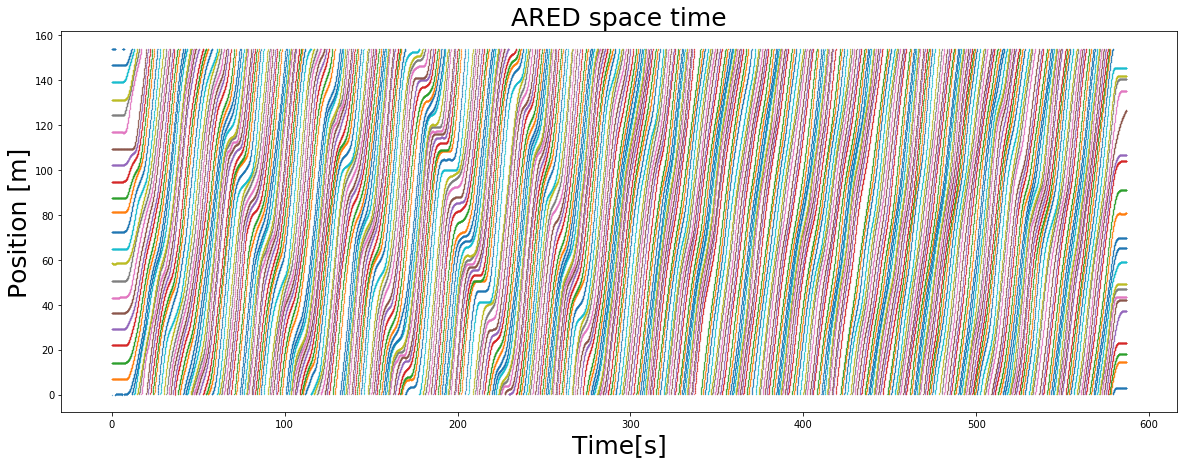

In [6]:
ring_length_effective = 153.9 #Amount of free space when car lengths are taken out

plt.figure(figsize=[20,7])
plt.plot(T_vals,np.mod(X_vals,ring_length_effective),'.',markersize=0.5)

plt.ylabel('Position [m]',fontsize=25)
plt.xlabel('Time[s]',fontsize=25)
plt.title('ARED space time',fontsize=25)

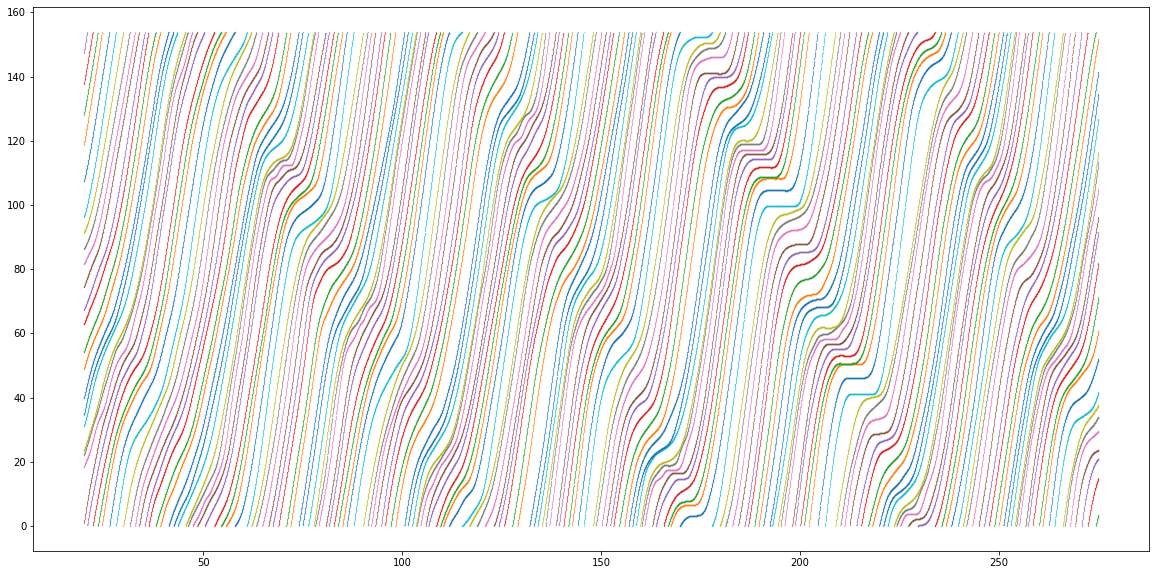

In [7]:
train_begin = 600
train_end = 275*30
 
V_train = V_vals[train_begin:train_end,:]
S_train = S_vals[train_begin:train_end,:]
VL_train = VL_vals[train_begin:train_end,:]
T_train = T_vals[train_begin:train_end,:]
X_train = X_vals[train_begin:train_end,:]

plt.figure(figsize=[20,10])
plt.plot(T_train,np.mod(X_train,ring_length_effective),'.',markersize=0.5)

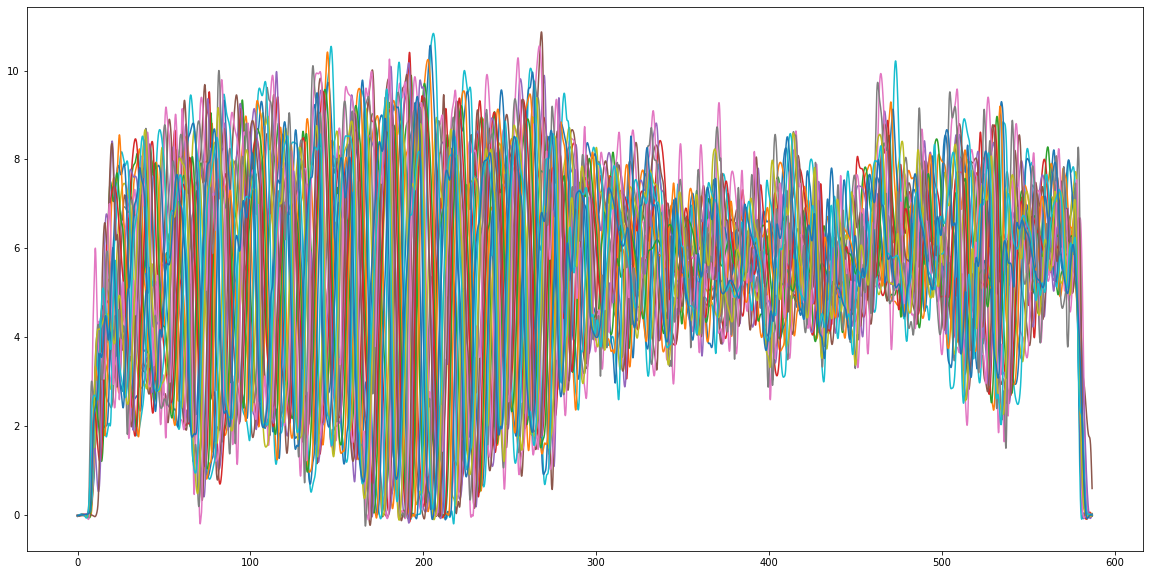

In [86]:
plt.figure(figsize=[20,10])
plt.plot(T_vals,V_vals)

In [12]:
from scipy.interpolate import interp1d

V_train = V_vals[train_begin:train_end,:]
S_train = S_vals[train_begin:train_end,:]
VL_train = VL_vals[train_begin:train_end,:]
T_train = T_vals[train_begin:train_end,:]
X_train = X_vals[train_begin:train_end,:]

V_train_resampled = []
S_train_resampled = []
T_train_resampled = []
X_train_resampled = []

veh_ids = range(21)

timeseries_dict_train = dict.fromkeys(veh_ids)

for veh_id in veh_ids:
    times = T_train[:,veh_id]
    speeds = V_train[:,veh_id]
    spacings = S_train[:,veh_id]
    lead_speeds = VL_train[:,veh_id]
    rel_vel = lead_speeds - speeds
    
    # resample everything to be at 10 herz so it works with detection hyper parameters:
    
    resampled_times = np.arange(times[0],times[-1],0.1)
    T_train_resampled.append(resampled_times)
    #speed
    speed_interp = interp1d(times, speeds, kind='cubic')
    resampled_speeds = speed_interp(resampled_times)
    V_train_resampled.append(resampled_speeds)
    #spacing
    spacing_interp = interp1d(times, spacings, kind='cubic')
    resampled_spacings = spacing_interp(resampled_times)
    S_train_resampled.append(resampled_spacings)
    #relative speed:
    rel_vel_interp = interp1d(times, rel_vel, kind='cubic')
    resampled_rel_vel = rel_vel_interp(resampled_times)
    #position:
    position_interp = interp1d(times, X_train[:,veh_id], kind='cubic')
    X_train_resampled.append(position_interp(resampled_times))
    
    
    data = np.array([resampled_times,resampled_speeds,resampled_spacings,resampled_rel_vel]).T
    
    timeseries_dict_train[veh_id] = data

    

V_train_resampled = np.array(V_train_resampled).T
S_train_resampled = np.array(S_train_resampled).T
T_train_resampled = np.array(T_train_resampled).T
X_train_resampled = np.array(X_train_resampled).T

print('Training data created.')

Training data created.


In [40]:
GPS_penetration_rate = 1.0
ARED_detector = train_ring_relative_detector(GPS_penetration_rate,timeseries_dict_train,model_name='ARED_detector',n_epoch=50)

Model: ARED_detector1.0percentGPS
Beginning training...
Creating new model.
Epoch 0, total loss 99680.027710, total predictions 2100, avg loss 47.466680 2022-04-30 15:07:39.293389
Saving model. Best loss: 47.46667986188616
Saving model. Best loss: 47.344174274262926
Saving model. Best loss: 40.70076177687872
Saving model. Best loss: 39.55036980038597
Saving model. Best loss: 38.27768142700195
Epoch 5, total loss 74903.426315, total predictions 2100, avg loss 35.668298 2022-04-30 15:08:20.031904
Saving model. Best loss: 35.66829824538458
Saving model. Best loss: 31.725698529198056
Saving model. Best loss: 26.230923160371326
Saving model. Best loss: 25.608674788702103
Saving model. Best loss: 23.992297116234187
Epoch 10, total loss 49331.073303, total predictions 2100, avg loss 23.490987 2022-04-30 15:09:00.675596
Saving model. Best loss: 23.490987287248885
Saving model. Best loss: 23.11487217857724
Saving model. Best loss: 22.654501375470844
Epoch 15, total loss 47068.183067, total pred

In [13]:
def get_losses(timeseries_dict,model,want_timeseries_plot=True):
    veh_ids = list(timeseries_dict.keys())
   
    num_veh_processed = 0

    testing_losses_dict = dict.fromkeys(veh_ids)

    for veh_id in veh_ids:
        timeseries_list = []
        
        speed = timeseries_dict[veh_id][:,1]
        accel = np.gradient(speed,.1)
        head_way = timeseries_dict[veh_id][:,2]
        rel_vel = timeseries_dict[veh_id][:,3]
        
        timeseries_list.append([speed,accel,head_way,rel_vel])

        timeseries_list = [speed,accel,head_way,rel_vel]

        _,loss = sliding_window_mult_feat(model,timeseries_list)

        testing_losses_dict[veh_id]=loss

        num_veh_processed+=1

        sys.stdout.write('\r'+'Vehicles processed: '+str(num_veh_processed)+'\r')

    print('\n')
    
    smoothed_losses = dict.fromkeys(veh_ids)
    time = timeseries_dict[veh_ids[0]][:,0]
    
    #Get smoothed loss values:
    for veh_id in veh_ids:
        loss = testing_losses_dict[veh_id]
        smoothed_loss = loss_smooth(time,loss)
            
        smoothed_losses[veh_id] =  loss_smooth(time,loss)

    
    if(want_timeseries_plot):
        plt.figure()
        
        for veh_id in veh_ids:
            smoothed_loss = smoothed_losses[veh_id]
            plt.plot(smoothed_loss)
        
    return smoothed_losses


print('Function for getting smoothed losses defined.')

Function for getting smoothed losses defined.


Vehicles processed: 21



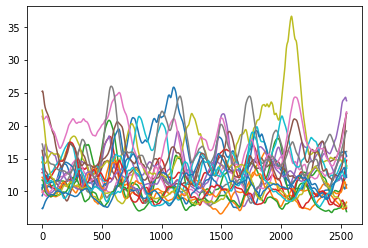

In [44]:
ARED_training_losses_dict = get_losses(timeseries_dict_train,model=ARED_detector)

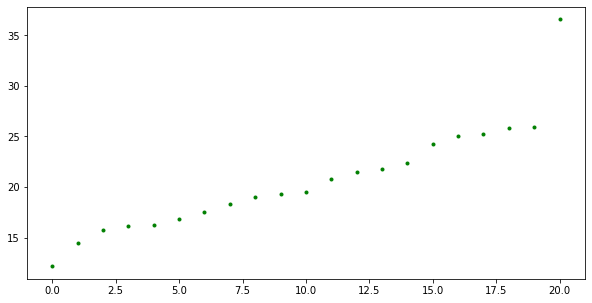

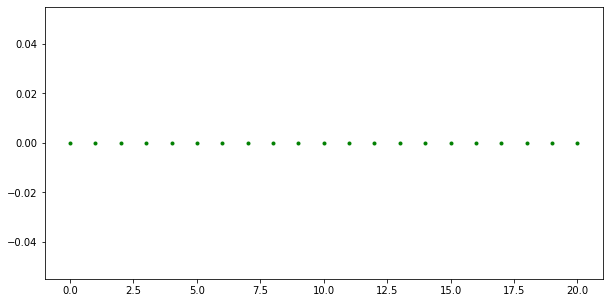

In [83]:
from sklearn.cluster import KMeans

def k_means_cluster(max_losses,cluster_diff=0.1):

    min_l = np.min(max_losses)
    max_l = np.max(max_losses)
    normalize_losses = (max_losses-min_l)/(max_l-min_l)
    X = normalize_losses
    kmeans = KMeans(n_clusters=2, random_state=0).fit(X.reshape(-1,1))
    labels = kmeans.labels_
    cluster_centroids = kmeans.cluster_centers_

    positive_labels = []
    negative_labels = []

    for i in range(len(X)):
        l = X[i]
        label = labels[i]
        if(label==0):negative_labels.append(l)
        else:positive_labels.append(l) 

    if(np.min(positive_labels)-cluster_diff > np.max(negative_labels)):
        return labels,cluster_centroids
    else:
        return np.zeros_like(labels),cluster_centroids
    
    
plt.figure(figsize=[10,5])
    
training_max_losses = []
for veh_id in veh_ids:
    max_loss = np.max(ARED_training_losses_dict[veh_id])
    training_max_losses.append(max_loss)

plt.plot(np.sort(training_max_losses),'g.')
    
cluster_diff = 0.02

training_labels,centroids_training = k_means_cluster(training_max_losses,cluster_diff=cluster_diff)
  
plt.figure(figsize=[10,5])    
plt.plot(training_labels,'g.')

In [55]:
test_begin = 275*30
test_end = 550*30
 
V_test = V_vals[test_begin:test_end,:]
S_test = S_vals[test_begin:test_end,:]
VL_test = VL_vals[test_begin:test_end,:]
T_test = T_vals[test_begin:test_end,:]
X_test = X_vals[test_begin:test_end,:]

V_test_resampled = []
S_test_resampled = []
T_test_resampled = []
X_test_resampled = []

veh_ids = range(21)

timeseries_dict_test = dict.fromkeys(veh_ids)

for veh_id in veh_ids:
    times = T_test[:,veh_id]
    speeds = V_test[:,veh_id]
    spacings = S_test[:,veh_id]
    lead_speeds = VL_test[:,veh_id]
    rel_vel = lead_speeds - speeds
    
    # resample everything to be at 10 herz so it works with detection hyper parameters:
    
    resampled_times = np.arange(times[0],times[-1],0.1)
    T_test_resampled.append(resampled_times)
    #speed
    speed_interp = interp1d(times, speeds, kind='cubic')
    resampled_speeds = speed_interp(resampled_times)
    V_test_resampled.append(resampled_speeds)
    #spacing
    spacing_interp = interp1d(times, spacings, kind='cubic')
    resampled_spacings = spacing_interp(resampled_times)
    S_test_resampled.append(resampled_spacings)
    #relative speed:
    rel_vel_interp = interp1d(times, rel_vel, kind='cubic')
    resampled_rel_vel = rel_vel_interp(resampled_times)
    #position:
    position_interp = interp1d(times, X_test[:,veh_id], kind='cubic')
    X_test_resampled.append(position_interp(resampled_times))
    
    
    data = np.array([resampled_times,resampled_speeds,resampled_spacings,resampled_rel_vel]).T
    
    timeseries_dict_test[veh_id] = data

    

V_test_resampled = np.array(V_test_resampled).T
S_test_resampled = np.array(S_test_resampled).T
T_test_resampled = np.array(T_test_resampled).T
X_test_resampled = np.array(X_test_resampled).T

print('Testing data created.')


Testing data created.


Vehicles processed: 21



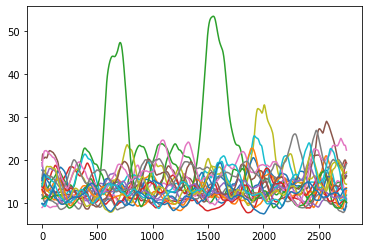

In [46]:
ARED_testing_losses_dict = get_losses(timeseries_dict_test,model=ARED_detector)

[[1.        ]
 [0.15510942]]


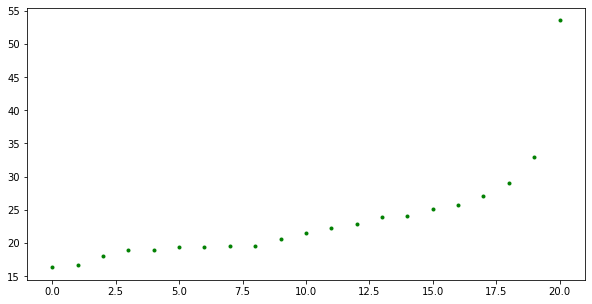

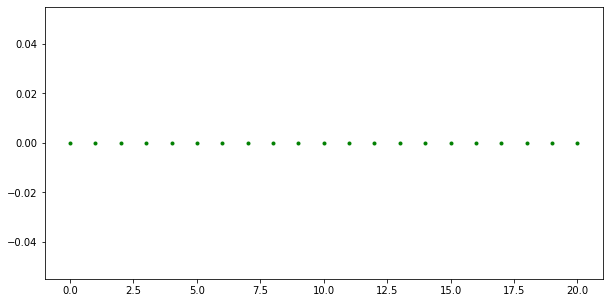

In [84]:
plt.figure(figsize=[10,5])
    
testing_max_losses = []
for veh_id in veh_ids:
    max_loss = np.max(ARED_testing_losses_dict[veh_id])
    testing_max_losses.append(max_loss)

plt.plot(np.sort(testing_max_losses),'g.')
    
cluster_diff = 0.00001

testing_labels,centroids_testing = k_means_cluster(testing_max_losses,cluster_diff=cluster_diff)

print(centroids_testing)


plt.figure(figsize=[10,5])    
plt.plot(testing_labels,'g.')

In [67]:
max_loss = 0
max_loss_veh_id = 0

for veh_id in veh_ids:
    curr_max_loss = np.max(ARED_testing_losses_dict[veh_id])
    if(curr_max_loss > max_loss):
        max_loss = curr_max_loss
        max_loss_veh_id = veh_id
        
print(max_loss_veh_id)

12


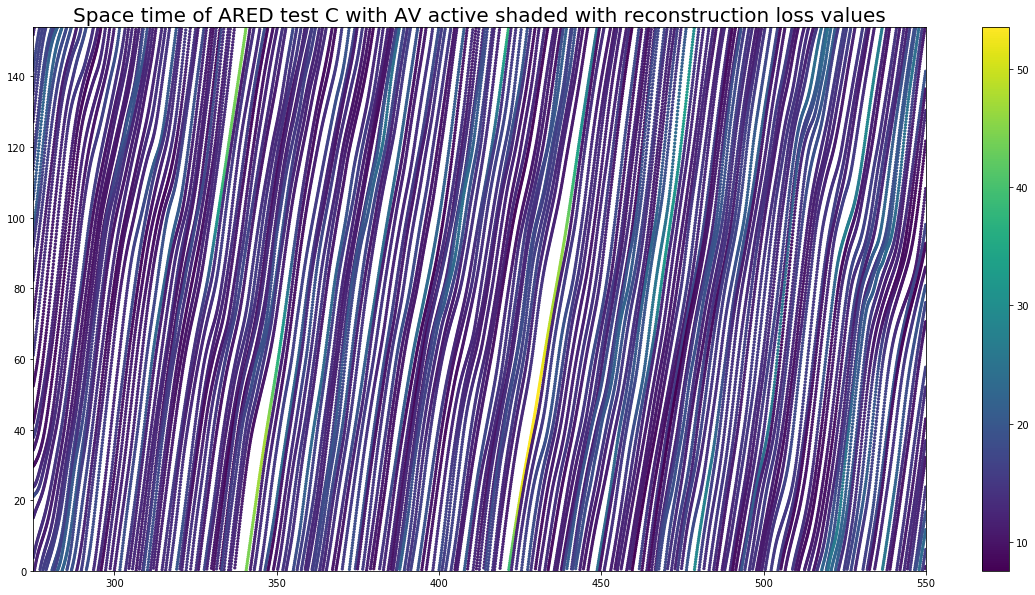

In [65]:
loss_vals = []
for veh_id in veh_ids:
    loss_vals.append(ARED_testing_losses_dict[veh_id])
    
loss_vals = np.array(loss_vals)
loss_vals = loss_vals.T

plt.figure(figsize=[20,10])
plt.subplot(2,2,1)




plt.scatter(T_test_resampled.flatten(),np.mod(X_test_resampled,ring_length_effective).flatten(),c=loss_vals.flatten(),s=5.0)
plt.title('Space time of ARED test C with AV active shaded with reconstruction loss values',fontsize=20)
plt.ylim([0,ring_length_effective])
plt.xlim([275,550])
plt.colorbar()